In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import joblib

from sklearn.decomposition import PCA
from transformers import BertTokenizer, AutoModel
from Preprocessing import *


c:\Users\LENOVO\GitHub\Jurnal-Clustering\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ScoopPredictor:
    def __init__(self, tokenizer, model, kmeans_model, threshold, pca_data, X_bert):
        self.tokenizer = tokenizer
        self.model = model
        self.kmeans_model = kmeans_model
        self.threshold = threshold
        self.pca_data = pca_data
        self.X_bert = X_bert

    def fit_new_data_to_pca(self, new_data):
        pca = PCA(n_components=self.pca_data.shape[1], random_state=0)
        pca.fit(self.X_bert)
        new_data_pca = pca.transform(new_data.reshape(1, -1))
        return new_data_pca

    def predict_scoop(self, title, abstract):
        processed_text = preprocess_text(title + abstract)
        encoded_dict = self.tokenizer.encode_plus(
            processed_text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoded_dict['input_ids'].to('cpu')
        attention_mask = encoded_dict['attention_mask'].to('cpu')

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            last_hidden_states = outputs.last_hidden_state
            new_embedding = last_hidden_states.cpu().numpy().reshape(1, -1)

        new_data_pca = self.fit_new_data_to_pca(new_embedding)
        distance_to_centroid = np.sqrt(np.sum((new_data_pca - self.kmeans_model.cluster_centers_) ** 2, axis=1))
        prediction = "in scoop" if distance_to_centroid <= self.threshold else "out scoop"
        return prediction, new_data_pca, distance_to_centroid


In [3]:
def plot_vector_distribution(vector_representation, kmeans_labels, scoop_labels, new_data_pca=None):
    pca = PCA(n_components=2, random_state=0)
    pca_result = pca.fit_transform(vector_representation)

    # label_ = ['inscoop', 'outscoop'] if len(np.unique(scoop_labels) == 2) else ['inscoop']

    scoop_labels[scoop_labels == 1] = 2
    scoop_labels[scoop_labels == -1] = 3

    df_pca = pd.DataFrame(pca_result, columns=['Dimension 1', 'Dimension 2'])
    df_pca['Scoop Label'] = scoop_labels

    cluster_palette = sns.color_palette('tab10', n_colors=2)
    # print(len(np.unique(scoop_labels)), np.unique(scoop_labels), scoop_labels)
    plt.figure(figsize=(8, 6))
    plot = sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Scoop Label', data=df_pca, palette=cluster_palette)
    # handles, labels = plot.get_legend_handles_labels()
    # plot.legend(handles, label_)
    plot.set(xlabel = None)
    plot.set(ylabel = None)
    plot.legend([],[], frameon=False)
    
    # Add centroids to the plot
    centroids = []
    for label in np.unique(kmeans_labels):
        centroid = np.mean(pca_result[kmeans_labels == label], axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', c='red', s=50, label='Centroids')
    
    if new_data_pca is not None:
        plt.scatter(new_data_pca[:, 0], new_data_pca[:, 1], c='green')
    # Show position of new PCA data
    
    plt.title('PCA Latent Representation with Centroids')
    plt.show()

In [4]:
def load_data(jurnal_id, jurnal_type):
    file_path = f"./src/{jurnal_type}/{jurnal_id}"
    filename_kmeans = f"{file_path}/{jurnal_id}_kmeans.pkl"
    kmeans_model = joblib.load(filename_kmeans)
    threshold = np.load(f"{file_path}/{jurnal_id}_threshold.npy")
    pca_data = np.load(f"{file_path}/{jurnal_id}_pca_data.npy")
    X_bert = np.load(f"{file_path}/{jurnal_id}_bert_data.npy")
    df_res = pd.read_csv(f"{file_path}/{jurnal_id}_data_jurnal.csv")
    return kmeans_model, threshold, pca_data, X_bert, df_res

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = AutoModel.from_pretrained('bert-base-multilingual-cased')

jurnal_id = 12
journal_type = 'sinta'

kmeans_model,  outscoop_threshold, pca_data, X_bert, df_res = load_data(jurnal_id, journal_type)
predictor = ScoopPredictor(tokenizer, model, kmeans_model,  outscoop_threshold, pca_data, X_bert)

inScoop_df = df_res[df_res['Label'] == 1]
outScoop_df = df_res[df_res['Label'] == -1]

# Mendapatkan koordinat pusat cluster
centroid = kmeans_model.cluster_centers_

# Menghitung jarak antara setiap titik data dengan centroid
jarak_ke_centroid = np.sqrt(np.sum((pca_data - centroid)**2, axis=1))

# Menentukan label untuk scoop dan outscoop
scoop_labels = np.ones(len(pca_data))
scoop_labels[jarak_ke_centroid > outscoop_threshold] = -1

inScoop_df = df_res[df_res['Label'] == 1]
outScoop_df = df_res[df_res['Label'] == -1]

# plot_vector_distribution(pca_data, kmeans_model.labels_, scoop_labels)

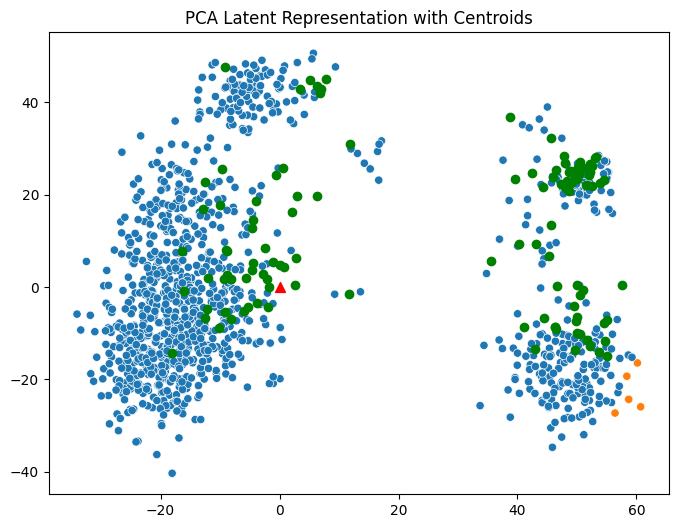

In [6]:
injected_data = pd.read_csv('data/data_sinta_cleaned.csv')
injected_data.dropna(inplace=True)

complement_journal = {
    1 : [4, 5, 7, 8, 9, 10, 11, 12],
    2 : [4, 5, 7, 8, 9, 10, 11, 12],
    3 : [4, 5, 7, 8, 9, 10, 11, 12],
    4 : [1, 2, 3, 6, 8, 10, 11],
    5 : [1, 2, 3, 6, 8, 10, 11],
    6 : [4, 5, 7, 8, 9, 10, 11, 12],
    7 : [4, 5, 8, 9, 10, 12],
    8 : [1, 2, 3, 4, 5, 6, 7, 9, 11, 12],
    9 : [1, 2, 3, 6, 8, 10, 11],
    10 : [1, 2, 3, 4, 5, 6, 7, 9, 11, 12],
    11 : [1, 2, 3, 4, 5, 6, 8, 9, 10, 12],
    12 : [1, 2, 3, 6, 8, 10, 11]
}   

new_data_pca = []
scoop_predictions = []
distances = []
test_data = injected_data[injected_data.jid.isin(complement_journal[jurnal_id])].sample(int(len(df_res) * 0.1))

for data in test_data.iloc:
    test_title = data.title
    test_abs = data.desc

    scoop_prediction, data_pca, distance = predictor.predict_scoop(test_title, test_abs)
    data_pca = np.squeeze(data_pca)

    scoop_predictions.append(scoop_prediction)
    distances.append(distance)
    new_data_pca.append(data_pca)

# scoop_prediction, new_data_pca, distance = predictor.predict_scoop(test_title, test_abs)
plot_vector_distribution(pca_data, kmeans_model.labels_, scoop_labels, np.array(new_data_pca))

